In [1]:
############
# Imports #
############

import json
import os

import torch
import wandb
from torch.utils.data import DataLoader

from model.cnn_classifier import model_4D
from model.finetune import FinetuneLoop
from model.pseudomask import Pseudomasks
from model.train import ClassifierTrainLoop
from utils.data_modules import ImageDataset, TestSet, filter_dataset

artifact_path = 'nadjaflechner/VGG_CAMs/classification_model:v45'

api = wandb.Api()
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=torch.device('cpu'))
model = model_4D()
model.load_state_dict(state_dict)
model.eval()

testset_dir = '/Users/nadja/Documents/UU/Thesis/Data/Verified_GTs'
depth_layer = 'hs'
normalize = True
finetune = False

test_set = TestSet(depth_layer, testset_dir, normalize)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
wandb:   1 of 1 files downloaded.  


In [44]:
from utils.data_modules import SaveFeatures
from torch.autograd import Variable
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, EigenCAM, GradCAMPlusPlus, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np

counter = 0

# im, lab, perc, gt_mask = next(iter(test_loader))
for im, lab, perc, gt_mask in test_loader:
    if perc > 0.05:
        break

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


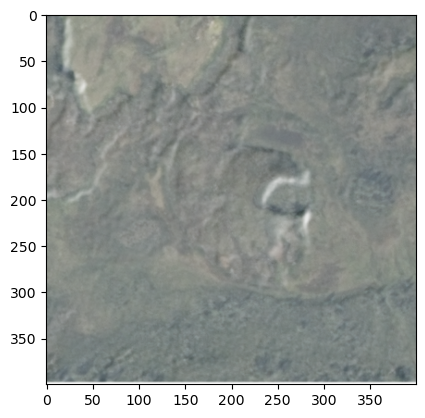

In [45]:
plt.imshow(im.squeeze().cpu().detach().permute(1,2,0).long().numpy())

running k-means on cpu..


[running kmeans]: 20it [00:01, 12.81it/s, center_shift=0.000013, iteration=20, tol=0.000100]


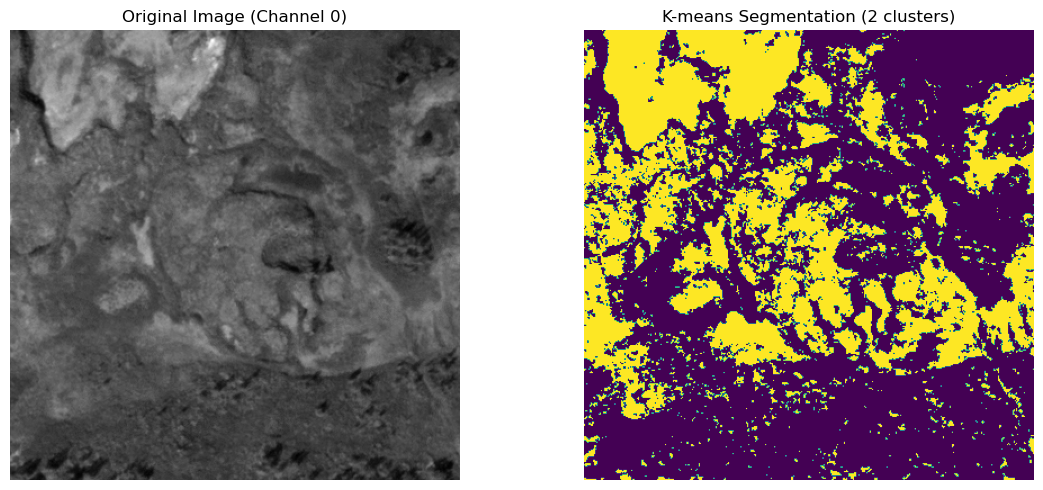

Cluster 0 size: 103062 pixels
Cluster 1 size: 56938 pixels


In [46]:
import torch
from kmeans_pytorch import kmeans
import matplotlib.pyplot as plt

# Assuming your image tensor is already defined
# image_tensor = torch.randn(1, 4, 400, 400)

# Reshape the tensor for clustering
reshaped_tensor = im.view(4, -1).t()

# Perform K-means clustering
num_clusters = 2
cluster_ids_x, cluster_centers = kmeans(
    X=reshaped_tensor,
    num_clusters=num_clusters,
    distance='euclidean',
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Reshape the cluster assignments back to the original image shape
segmentation_mask = cluster_ids_x.view(400, 400)

# Plot the original image (using the first channel for visualization)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(im[0, 0].numpy(), cmap='gray')
plt.title('Original Image (Channel 0)')
plt.axis('off')

# Plot the segmentation result
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask.numpy(), cmap='viridis')
plt.title('K-means Segmentation (2 clusters)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Print cluster sizes
for i in range(num_clusters):
    print(f"Cluster {i} size: {(segmentation_mask == i).sum().item()} pixels")

In [49]:
im[:, 3, :, :].shape

torch.Size([1, 400, 400])

running k-means on cpu..


[running kmeans]: 26it [00:01, 14.12it/s, center_shift=0.000000, iteration=26, tol=0.000100] 


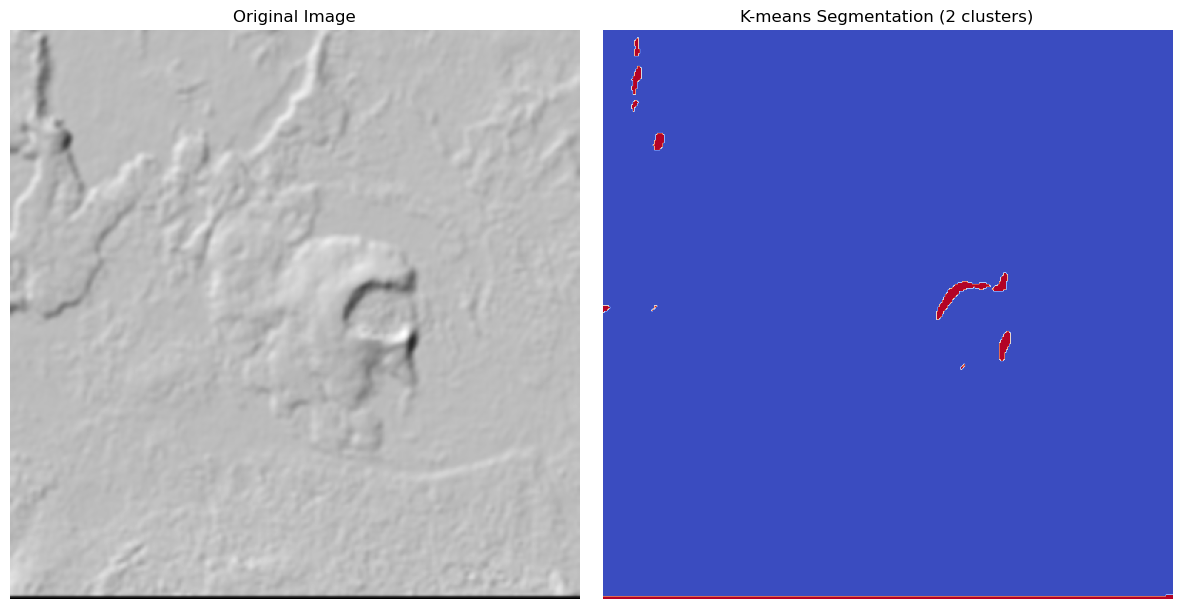

In [50]:
import torch
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans

# Assuming your image is already a PyTorch tensor of shape [1, 400, 400]
# If not, you'll need to load and convert it first
image = im[:, 3, :, :] # Replace this with your actual image tensor

# Reshape the image for clustering
X = image.view(-1, 1)  # Reshape to [160000, 1]

# Perform k-means clustering
num_clusters = 2
cluster_ids_x, cluster_centers = kmeans(
    X=X, num_clusters=num_clusters, distance='euclidean', device=torch.device('cpu')
)

# Reshape cluster_ids_x back to image shape
segmentation = cluster_ids_x.view(400, 400)

# Plot the original image and the segmentation result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
ax1.imshow(image.squeeze(), cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

# Plot segmentation result
ax2.imshow(segmentation, cmap='coolwarm')
ax2.set_title('K-means Segmentation (2 clusters)')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [48]:
import torch
from kmeans_pytorch import kmeans
import matplotlib.pyplot as plt

# Assuming your image tensor is already defined
# image_tensor = torch.randn(1, 4, 400, 400)

# Reshape the tensor for clustering
reshaped_tensor = im.view(4, -1).t()

# Perform K-means clustering
num_clusters = 2
cluster_ids_x, cluster_centers = kmeans(
    X=reshaped_tensor,
    num_clusters=num_clusters,
    distance='euclidean',
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Reshape the cluster assignments back to the original image shape
segmentation_mask = cluster_ids_x.view(400, 400)

# Plot the original image (using the first channel for visualization)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(im[0, 0].numpy(), cmap='gray')
plt.title('Original Image (Channel 0)')
plt.axis('off')

# Plot the segmentation result
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask.numpy(), cmap='viridis')
plt.title('K-means Segmentation (2 clusters)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Print cluster sizes
for i in range(num_clusters):
    print(f"Cluster {i} size: {(segmentation_mask == i).sum().item()} pixels")

running k-means on cpu..


[running kmeans]: 0it [00:00, ?it/s]

[running kmeans]: 5it [00:01,  4.82it/s, center_shift=0.000000, iteration=5, tol=0.000100]   


RuntimeError: shape '[400, 400]' is invalid for input of size 640000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


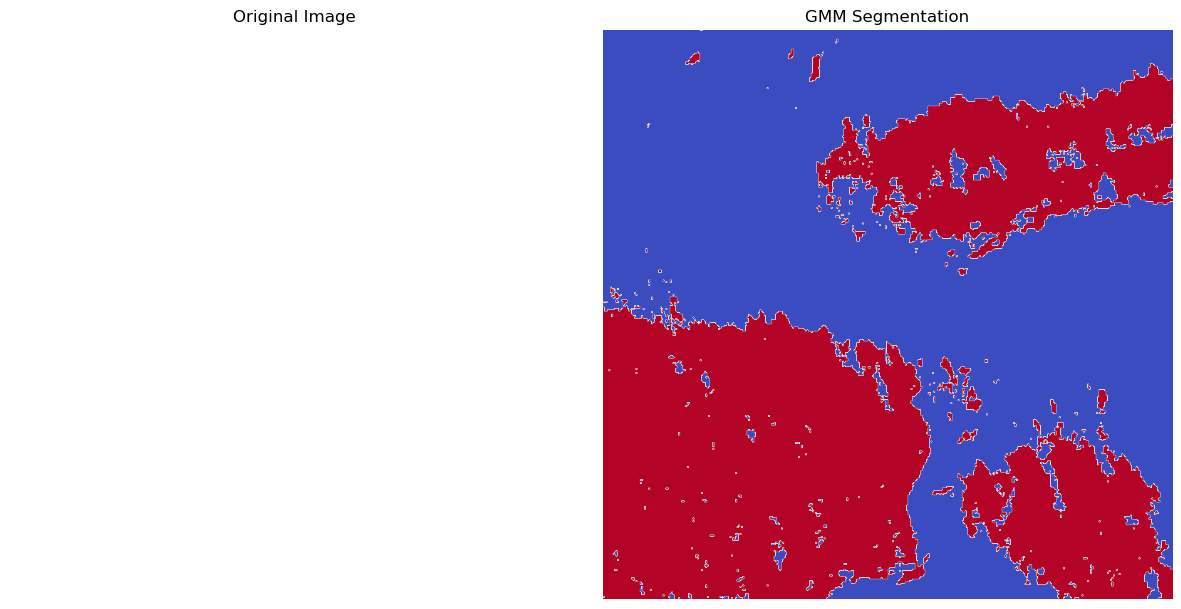

In [35]:
import torch
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming your image tensor is named 'image' and has shape [1, 4, 400, 400]
# If it's not already, ensure it's on CPU and converted to numpy
image = im.cpu().numpy()

# Reshape the image to be 2D: (pixels, features)
image_2d = image.reshape(1, 4, -1).squeeze().T  # Shape: (160000, 4)

# Fit GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(image_2d)

# Predict clusters
labels = gmm.predict(image_2d)

# Reshape labels back to image shape
segmentation = labels.reshape(400, 400)

# Plot original image (using first 3 channels as RGB) and segmentation result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
ax1.imshow(im.squeeze().cpu().detach().permute(1,2,0).long().numpy())  # Assuming first 3 channels are RGB
ax1.set_title('Original Image')
ax1.axis('off')

# Plot segmentation result
ax2.imshow(segmentation, cmap='coolwarm')
ax2.set_title('GMM Segmentation')
ax2.axis('off')

plt.tight_layout()
plt.show()

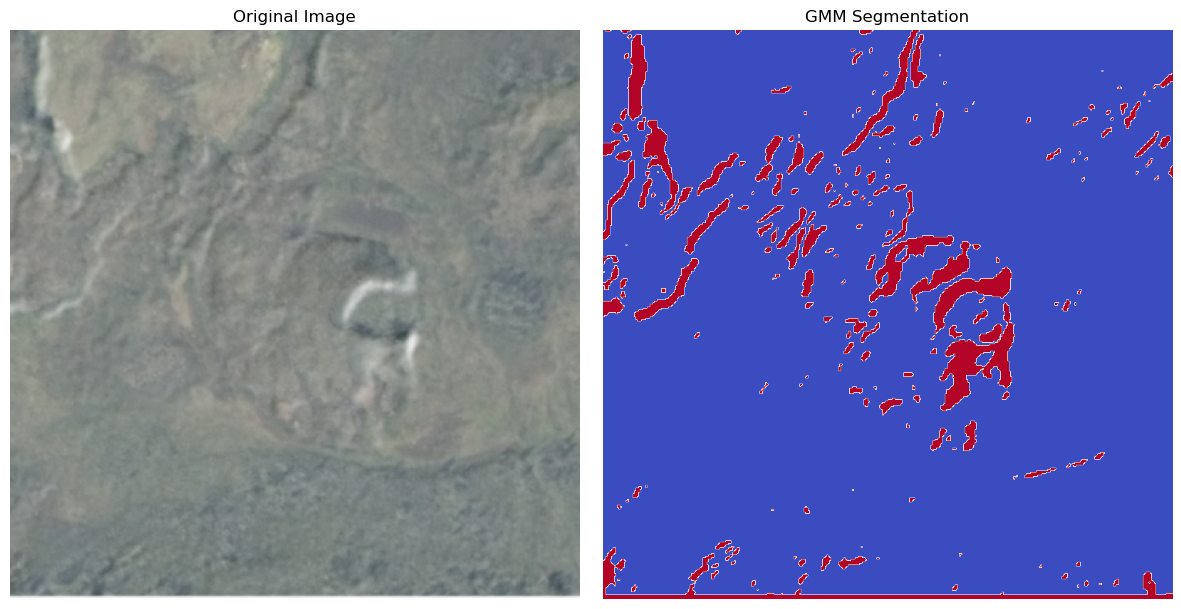

In [52]:
import torch
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming your image tensor is named 'image' and has shape [1, 4, 400, 400]
# If it's not already, ensure it's on CPU and converted to numpy
image = im[:, 3, :, :] # Replace this with your actual image tensor

# Reshape the image to be 2D: (pixels, features)
image_2d = image.view(-1, 1)  # Reshape to [160000, 1]

# Fit GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(image_2d)

# Predict clusters
labels = gmm.predict(image_2d)

# Reshape labels back to image shape
segmentation = labels.reshape(400, 400)

# Plot original image (using first 3 channels as RGB) and segmentation result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
ax1.imshow(im.squeeze().cpu().detach().permute(1,2,0).long().numpy())  # Assuming first 3 channels are RGB
ax1.set_title('Original Image')
ax1.axis('off')

# Plot segmentation result
ax2.imshow(segmentation, cmap='coolwarm')
ax2.set_title('GMM Segmentation')
ax2.axis('off')

plt.tight_layout()
plt.show()

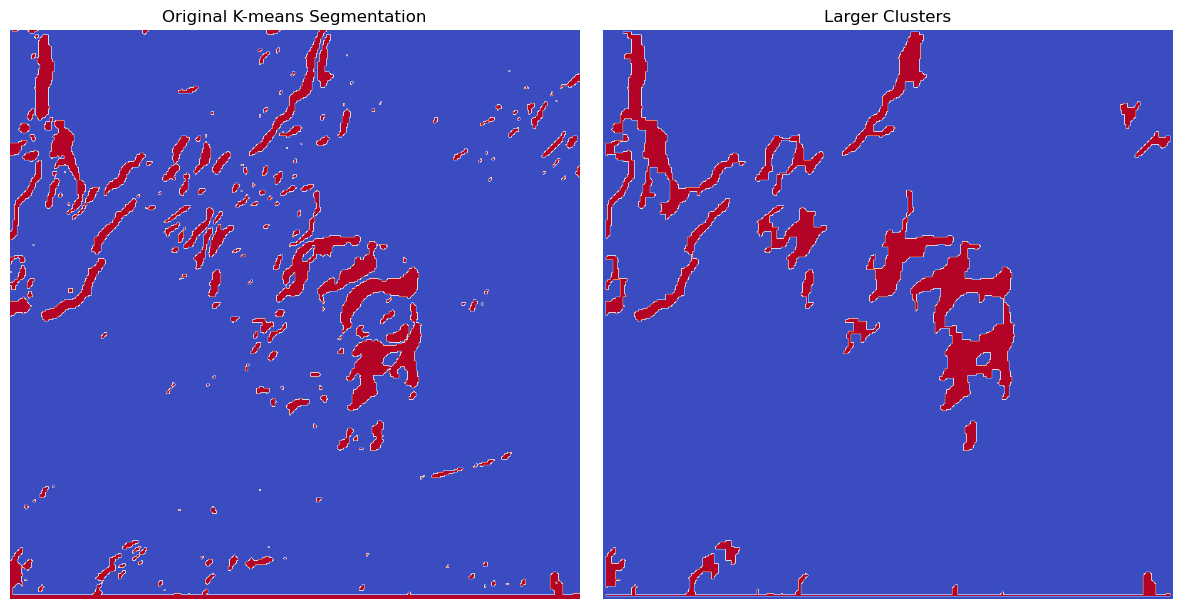

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure

# Assuming 'segmentation' is your initial k-means segmentation result
# Convert to numpy array if it's a PyTorch tensor
segmentation_np = segmentation.numpy() if isinstance(segmentation, torch.Tensor) else segmentation

# Function to create larger clusters
def create_larger_clusters(seg_mask, min_size=100):
    # Apply morphological closing to connect nearby regions
    struct = ndimage.generate_binary_structure(2, 2)
    closed = ndimage.binary_closing(seg_mask, structure=struct, iterations=2)
    
    # Label connected components
    labeled, num_features = ndimage.label(closed)
    
    # Remove small clusters
    sizes = ndimage.sum(closed, labeled, range(num_features + 1))
    mask_sizes = sizes < min_size
    remove_pixel = mask_sizes[labeled]
    labeled[remove_pixel] = 0
    
    # Relabel remaining clusters
    labels_id = np.unique(labeled)
    labels_id = labels_id[labels_id != 0]
    new_labeled = np.zeros_like(labeled)
    for i, label in enumerate(labels_id):
        new_labeled[labeled == label] = i + 1
    
    return new_labeled

# Create larger clusters for each class
larger_clusters = np.zeros_like(segmentation_np)
for class_id in range(2):  # Assuming 2 classes (0 and 1)
    class_mask = (segmentation_np == class_id).astype(int)
    larger_class_clusters = create_larger_clusters(class_mask)
    larger_clusters[larger_class_clusters > 0] = class_id

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original k-means segmentation
ax1.imshow(segmentation_np, cmap='coolwarm')
ax1.set_title('Original K-means Segmentation')
ax1.axis('off')

# Plot larger clusters
ax2.imshow(larger_clusters, cmap='coolwarm')
ax2.set_title('Larger Clusters')
ax2.axis('off')

plt.tight_layout()
plt.show()

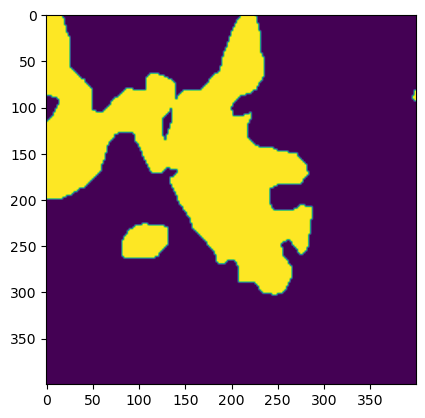

In [55]:
plt.imshow(gt_mask.squeeze().view(400,400,1))

In [29]:
cluster_centers

tensor([[ 87.6124,  88.6912,  88.7674,  87.7029],
        [ 51.5421,  49.8542,  49.8951,  51.6619],
        [ 71.4779,  71.7057,  71.6371,  71.4069],
        [179.4995, 179.5146, 179.5141, 179.4976]])

In [33]:
segmentation = cluster_ids_x.reshape(400, 400,1)

In [23]:
segmentation.shape

torch.Size([400, 400])

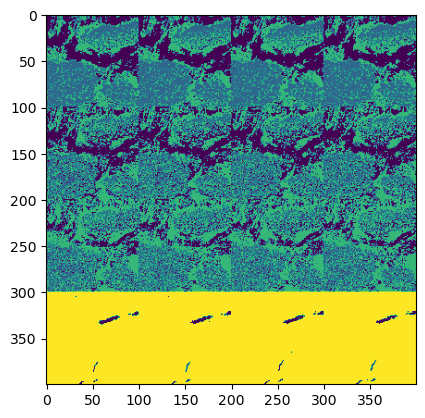

In [25]:
plt.imshow(segmentation)

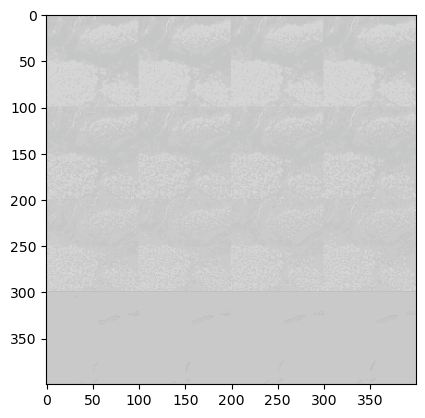

In [31]:
# convert data into 8-bit values
centers = np.uint8(cluster_centers)
segmented_data = centers[cluster_ids_x.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((400,400,4))
 
plt.imshow(segmented_image)